In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data Exploration

In [2]:
df = pd.read_csv('accident.csv')
df.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0


In [3]:
print(f'Dataset has {df.isna().sum().sum()} Nulls')
print(df.isna().sum())
print(f'Dataset has {df.duplicated().sum()} duplicates')

Dataset has 4 Nulls
Age                0
Gender             1
Speed_of_Impact    3
Helmet_Used        0
Seatbelt_Used      0
Survived           0
dtype: int64
Dataset has 0 duplicates


In [4]:
df.describe()

,Age,Speed_of_Impact,Survived
count,200.00000,197.000000,200.00000
mean,43.42500,70.441624,0.50500
std,14.94191,30.125298,0.50123
min,18.00000,20.000000,0.00000
25%,31.00000,43.000000,0.00000
50%,43.50000,71.000000,1.00000
75%,56.00000,95.000000,1.00000
max,69.00000,119.000000,1.00000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Gender           199 non-null    object 
 2   Speed_of_Impact  197 non-null    float64
 3   Helmet_Used      200 non-null    object 
 4   Seatbelt_Used    200 non-null    object 
 5   Survived         200 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB


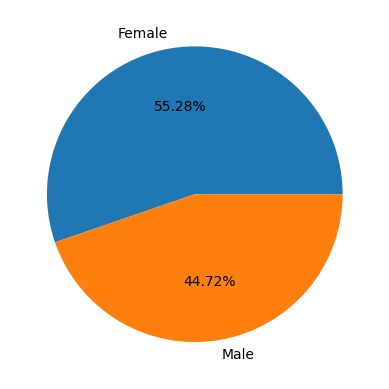

In [6]:
v = df['Gender'].value_counts().values
l = df['Gender'].value_counts().index
plt.pie(v, labels=l, autopct="%1.2f%%")
plt.show()

* Gender column is nearly balanced, so model is less likely to be biased

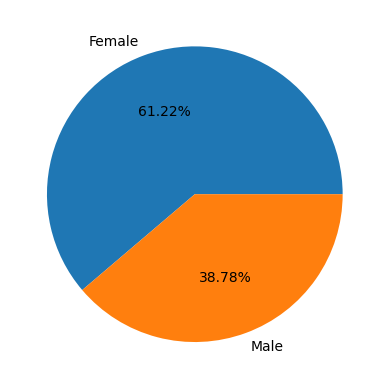

In [7]:
v = df[df['Survived'] == 0]['Gender'].value_counts().values
l = df[df['Survived'] == 0]['Gender'].value_counts().index
plt.pie(v, labels=l, autopct="%1.2f%%")
plt.show()

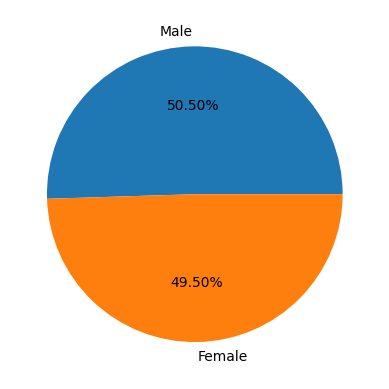

In [8]:
v = df[df['Survived'] == 1]['Gender'].value_counts().values
l = df[df['Survived'] == 1]['Gender'].value_counts().index
plt.pie(v, labels=l, autopct="%1.2f%%")
plt.show()

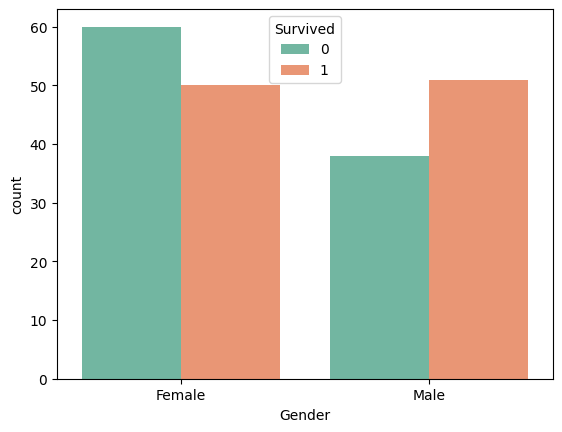

In [9]:
sns.countplot(x='Gender', hue='Survived', data=df, palette = "Set2")
plt.show()

* Females are more likely to die in an accident than males.

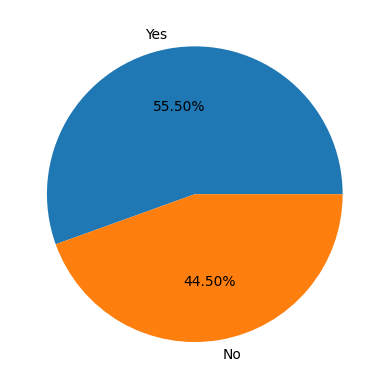

In [10]:
v = df['Helmet_Used'].value_counts().values
l = df['Helmet_Used'].value_counts().index
plt.pie(v, labels=l, autopct="%1.2f%%")
plt.show()

* Helmet_Used column is balanced

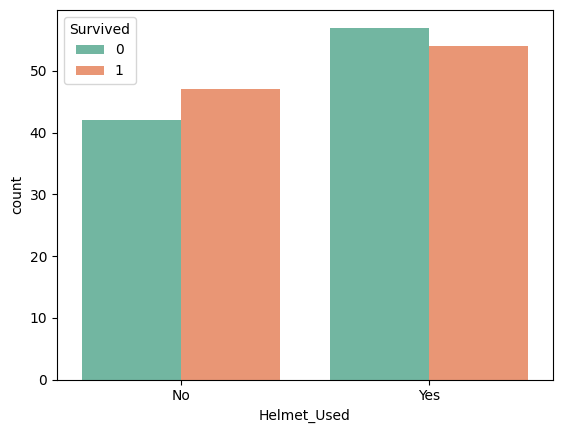

In [11]:
sns.countplot(x='Helmet_Used', hue='Survived', data=df, palette = "Set2")
plt.show()

* More people survived while no helmets used than those who didn't survive.
* Number of people who didn't survive while using a helmet is slightly higher than those who did survive.

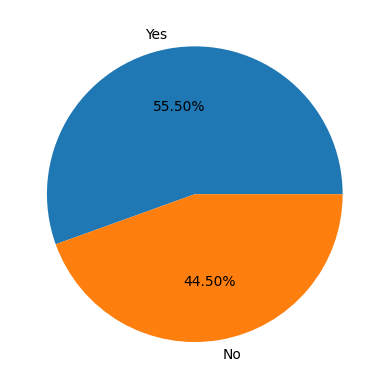

In [12]:
v = df['Seatbelt_Used'].value_counts().values
l = df['Seatbelt_Used'].value_counts().index
plt.pie(v, labels=l, autopct="%1.2f%%")
plt.show()

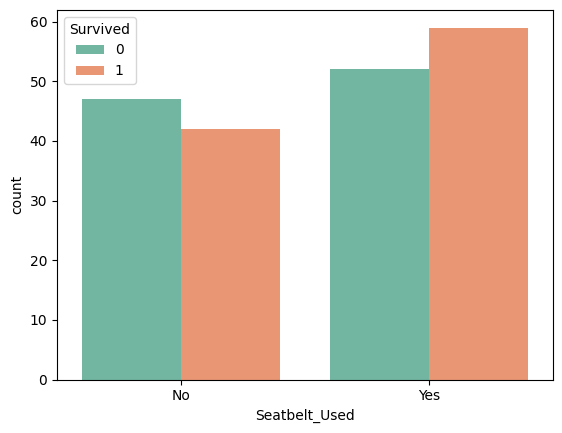

In [13]:
sns.countplot(x='Seatbelt_Used', hue='Survived', data=df, palette = "Set2")
plt.show()

* Number of people who did not survive without a seatbelt on is slightly higher than those who did survive.
* People with seatbelt on have higher chances of survival.

In [14]:
wearing_seatbelts = df[(df['Seatbelt_Used'] == 'Yes') & (df['Survived'] == 0)]
print(f'Percentage of accident victims who were wearing seatbelts {(wearing_seatbelts.shape[0]/df.shape[0])*100}%')

Percentage of accident victims who were wearing seatbelts 26.0%


Number of victims with both seatbelt and helmet on is 34


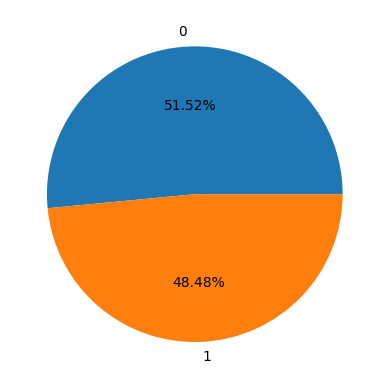

In [15]:
seatbelt_and_helmet_used = df[(df['Seatbelt_Used'] == 'Yes') & (df['Helmet_Used'] == 'Yes')]
print(f'Number of victims with both seatbelt and helmet on is {len(seatbelt_and_helmet_used[seatbelt_and_helmet_used["Survived"] == 0])}')
v = seatbelt_and_helmet_used['Survived'].value_counts().values
l = seatbelt_and_helmet_used['Survived'].value_counts().index
plt.pie(v, labels=l, autopct="%1.2f%%")
plt.show()

* It doesn't seem to have an effect

In [16]:
df.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0


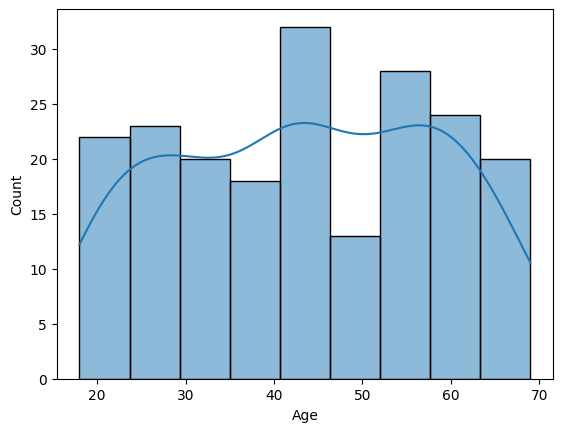

In [17]:
sns.histplot(df['Age'], kde=True)
plt.show()

In [18]:
print(f'The average age of accident victims is {np.round(df[df['Survived'] == 0]['Age'].mean(), 2)}')

The average age of accident victims is 41.77


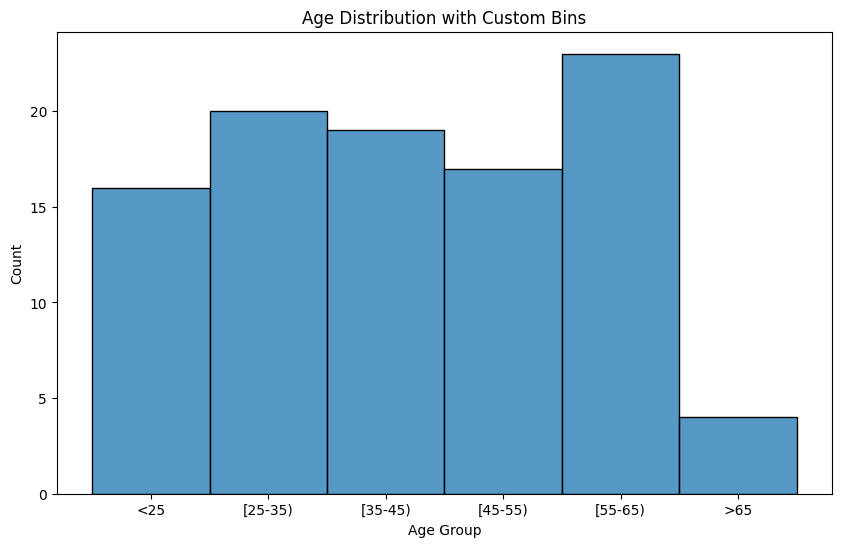

In [19]:
bins = [-np.inf, 25, 35, 45, 55, 65, np.inf]
labels = ['<25', '[25-35)', '[35-45)', '[45-55)', '[55-65)', '>65']



plt.figure(figsize=(10, 6))
sns.histplot(pd.cut(df[df['Survived'] == 0]['Age'], bins=bins, labels=labels, right=False))
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution with Custom Bins')
plt.show()


* Ages between 55 and 64 survival chances are low

In [20]:
print(f'Average age of accident victims is {round(df[df['Survived'] == 0]['Age'].mean())}')

Average age of accident victims is 42


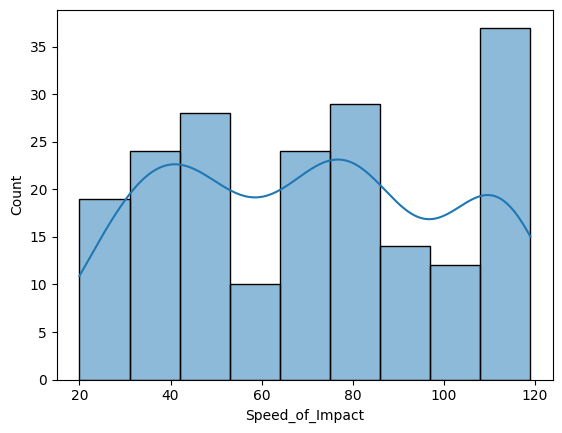

In [21]:
sns.histplot(df['Speed_of_Impact'], kde=True)
plt.show()

In [22]:
print(f'Highest speed recorded is {df['Speed_of_Impact'].max()}')
high_speed = pd.DataFrame(df[df['Speed_of_Impact'] == df['Speed_of_Impact'].max()])
display(high_speed)
print(f'{high_speed[high_speed['Survived'] == 0].shape[0]/high_speed.shape[0] * 100}% of people driving with maximum speed did not survive')

Highest speed recorded is 119.0


,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
174,24,Female,119.0,Yes,Yes,0
180,62,Female,119.0,Yes,Yes,1


50.0% of people driving with maximum speed did not survive


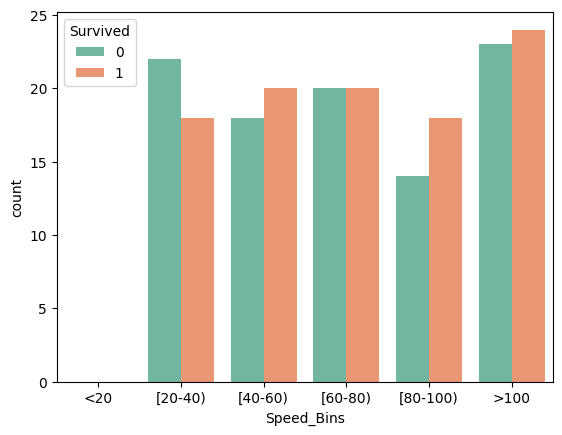

In [23]:
bins = [-np.inf, 20, 40, 60, 80, 100, np.inf]
labels = ['<20', '[20-40)', '[40-60)', '[60-80)', '[80-100)', '>100']
df['Speed_Bins'] = pd.cut(df['Speed_of_Impact'], bins=bins, labels=labels, right=False)
sns.countplot(x='Speed_Bins', hue='Survived', data=df, palette = "Set2")
plt.show()

* People driving above 100 got the lowest survival chances

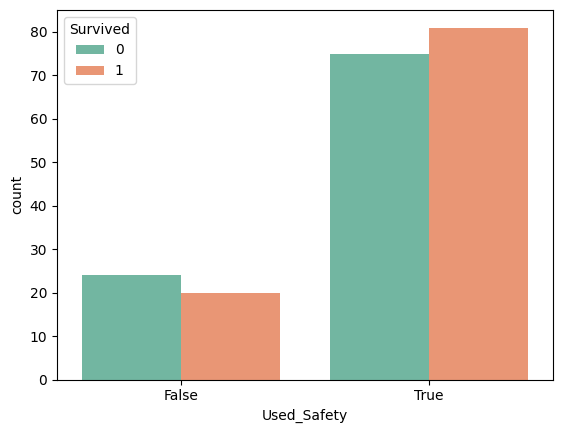

In [24]:
df['Used_Safety'] = (df['Helmet_Used'] == 'Yes') | (df['Seatbelt_Used'] == 'Yes')
sns.countplot(x='Used_Safety', hue='Survived', data=df, palette = "Set2")
plt.show()

* A lot of people used safety measures and most of those who used it did survive

## Data Cleansing

In [25]:
print(f'Number of nulls in dataset is {df.isna().sum().sum()} before imputation')
print(df.isna().sum())

Number of nulls in dataset is 7 before imputation
Age                0
Gender             1
Speed_of_Impact    3
Helmet_Used        0
Seatbelt_Used      0
Survived           0
Speed_Bins         3
Used_Safety        0
dtype: int64


In [26]:
imputer = KNNImputer(n_neighbors=5)

df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df = df.drop(columns=['Helmet_Used', 'Seatbelt_Used', 'Speed_Bins'])
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(exclude=['number']).columns

df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
df = pd.concat([df[numerical_cols], df[categorical_cols]], axis=1)


In [27]:
print(f'Number of nulls in dataset is {df.isna().sum().sum()} after imputation')
print(df.isna().sum())
df.head()

Number of nulls in dataset is 0 after imputation
Age                0
Speed_of_Impact    0
Survived           0
Gender             0
Used_Safety        0
dtype: int64


,Age,Speed_of_Impact,Survived,Gender,Used_Safety
0,56.0,27.0,1.0,Female,False
1,69.0,46.0,1.0,Female,True
2,46.0,46.0,0.0,Male,True
3,32.0,117.0,0.0,Male,True
4,60.0,40.0,0.0,Female,True


## Data Encoding

In [28]:
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df[['Gender']])
df['Gender'] = df['Gender'].astype(np.float64)

e:\Programes\python\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
print(df['Used_Safety'].dtype)
df['Used_Safety'] = df['Used_Safety'].astype(np.float64)
df.head()

bool


,Age,Speed_of_Impact,Survived,Gender,Used_Safety
0,56.0,27.0,1.0,0.0,0.0
1,69.0,46.0,1.0,0.0,1.0
2,46.0,46.0,0.0,1.0,1.0
3,32.0,117.0,0.0,1.0,1.0
4,60.0,40.0,0.0,0.0,1.0


## Data Scaling & Transformation

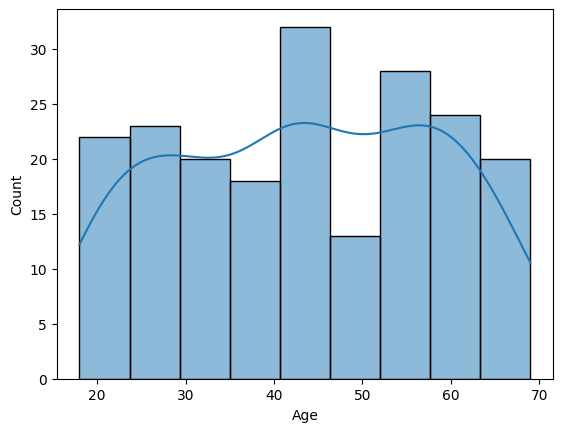

In [30]:
sns.histplot(df['Age'], kde=True)
plt.show()

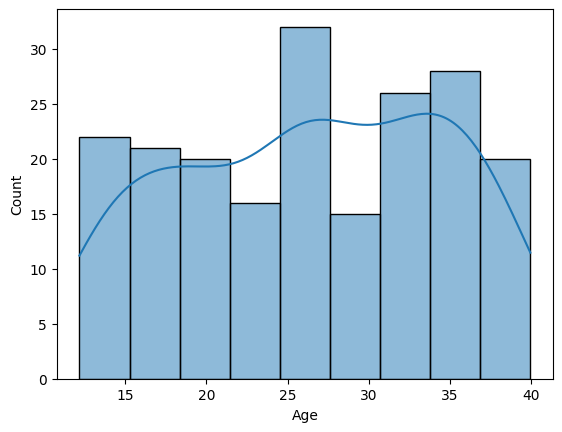

In [31]:
df['Age'], fitted_lambda = stats.boxcox(df['Age'])
sns.histplot(df['Age'], kde=True)
plt.show()

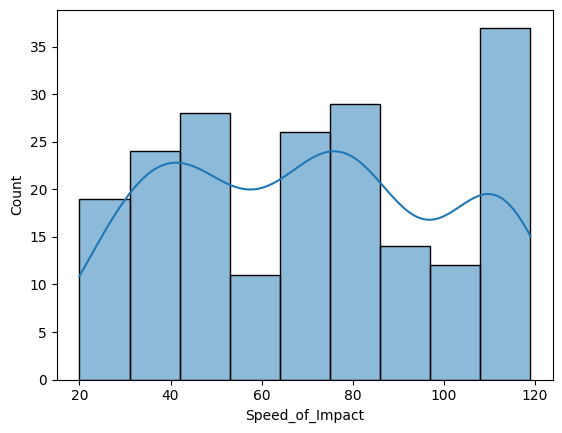

In [32]:
sns.histplot(df['Speed_of_Impact'], kde=True)
plt.show()

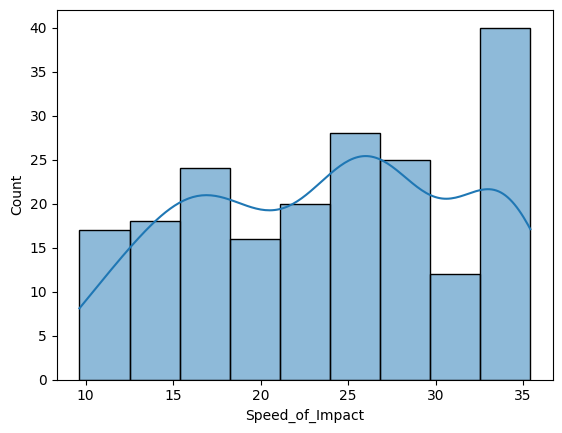

In [33]:
df['Speed_of_Impact'], fitted_lambda = stats.boxcox(df['Speed_of_Impact'])
sns.histplot(df['Speed_of_Impact'], kde=True)
plt.show()

In [34]:
scaler = RobustScaler()
for col in ['Age', 'Speed_of_Impact']:
    df[col] = scaler.fit_transform(df[[col]])   
df

,Age,Speed_of_Impact,Survived,Gender,Used_Safety
0,0.488016,-0.951442,1.0,0.0,0.0
1,0.976752,-0.503743,1.0,0.0,1.0
2,0.099287,-0.503743,0.0,1.0,1.0
3,-0.469916,0.794129,0.0,1.0,1.0
4,0.640210,-0.637091,0.0,0.0,1.0
...,...,...,...,...,...
195,0.976752,0.697328,1.0,0.0,1.0
196,-0.554276,-0.396941,1.0,0.0,1.0
197,0.564329,0.681030,1.0,1.0,1.0
198,-0.991831,0.565541,1.0,1.0,1.0


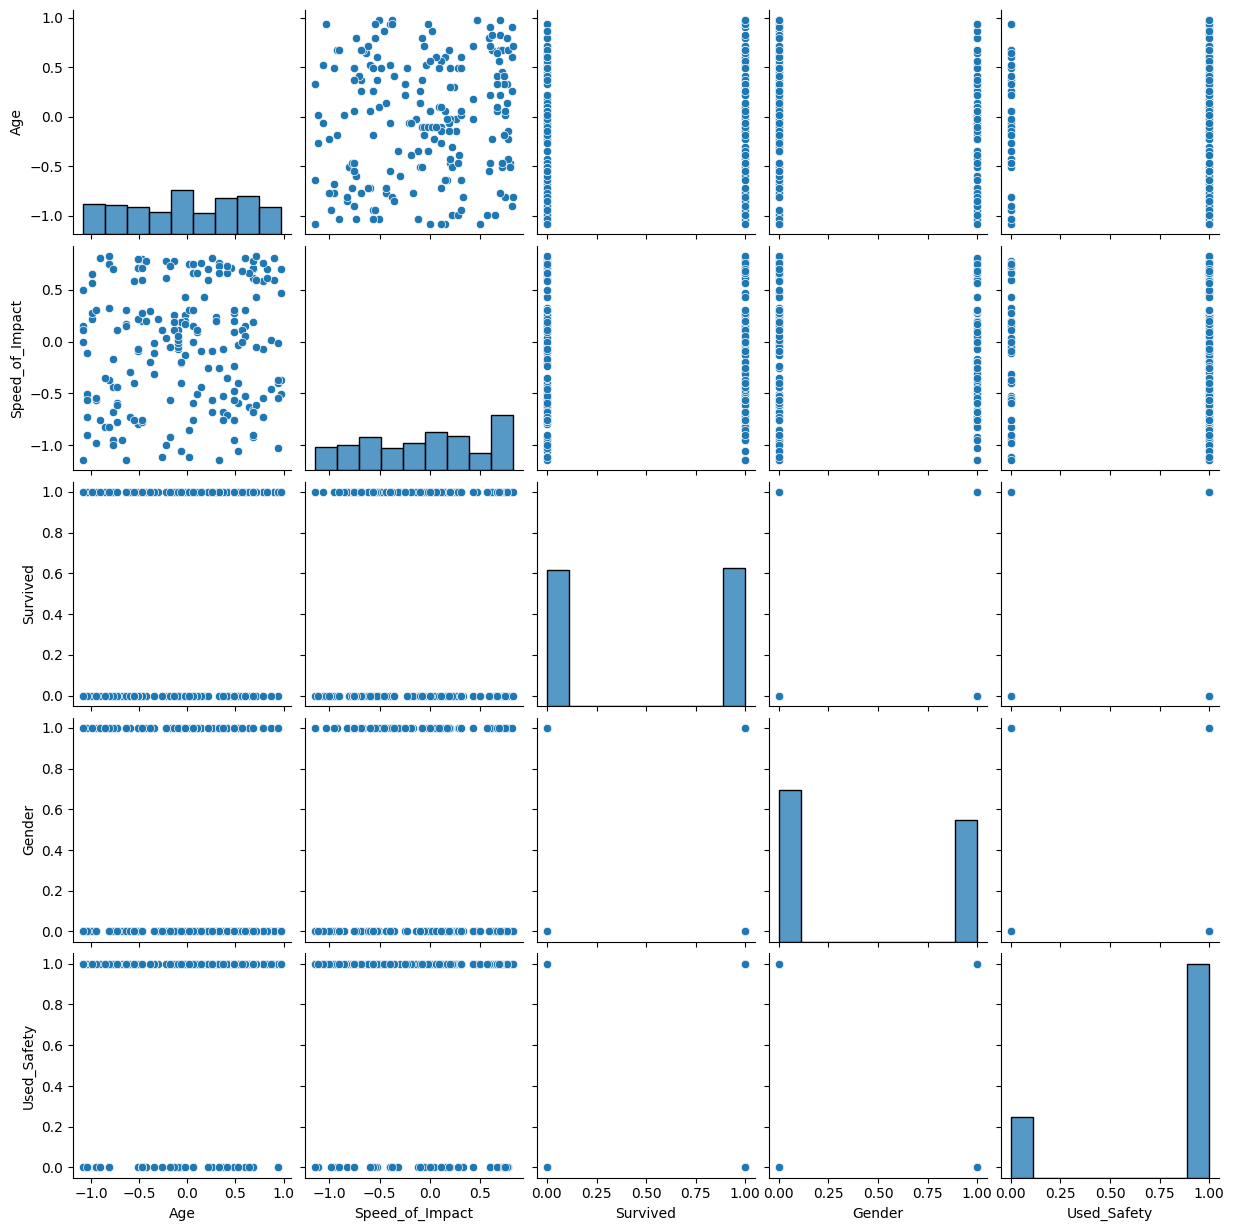

In [35]:
sns.pairplot(df)  # Plot pairwise relationships
plt.show()


* Binary features like Gender & Used_Safety are not helpful while predicting survivability because it is a binary vs binary relationship

## Model Selection

### Logistic Regression

Accuracy: 0.60
              precision    recall  f1-score   support

         0.0       0.71      0.45      0.56        22
         1.0       0.54      0.78      0.64        18

    accuracy                           0.60        40
   macro avg       0.63      0.62      0.60        40
weighted avg       0.64      0.60      0.59        40



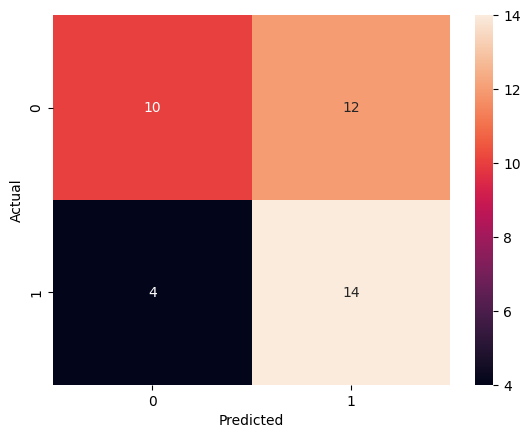

In [36]:
X = df[['Age', 'Speed_of_Impact']]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### KNN

Accuracy: 0.55
              precision    recall  f1-score   support

         0.0       0.60      0.55      0.57        22
         1.0       0.50      0.56      0.53        18

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.55      0.55      0.55        40



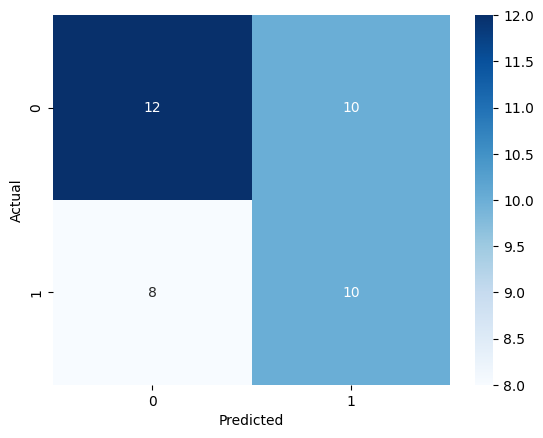

In [37]:
X = df[['Age', 'Speed_of_Impact', 'Gender', 'Used_Safety']]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
     